In [1]:
from Brainmets.utils import *
from Brainmets.dataset import *
from Brainmets.augmentations import Transformer
from Brainmets.losses import *
from Brainmets.trainer import *
from Brainmets.evaluation import *

Using TensorFlow backend.


In [2]:
device = torch.device('cuda: 1')
model = ResidualUNet3D(1, 1, True).to(device)
model_name = 'trained_models/nearest/Baseline-Diceloss-test_3-0.001/epoch_38_val_score=0.7961517106553521.pth'
state_dict = torch.load(model_name)

[16, 32, 64, 128, 256, 512]


In [3]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
data_path = Path('/home/chens/practicum/MEDomicsLab-develop-brainmets/model_training/3_unet_3d_residual/data/')
data = 'manuscript_1_datasets_first_tx_necrotic'
df = pd.read_csv(data_path/f'{data}.csv')

In [8]:
train_df = df[df['split'] == 'train'].sample(frac=1)
valid_df = df[df['split'] == 'valid'].sample(frac=1)
test_df = df[df['split'] == 'test'].sample(frac=1)

train_img_files = list(train_df['img_files'])
train_mask_files = list(train_df['mask_files'])
valid_img_files = list(valid_df['img_files'])
valid_mask_files = list(valid_df['mask_files'])
test_img_files = list(test_df['img_files'])
test_mask_files = list(test_df['mask_files'])

# train_dataset = MetDataSet(train_df)
# valid_dataset = MetDataSet(valid_df)
# test_dataset = MetDataSet(test_df)

In [9]:
from scipy import ndimage

In [10]:
structure_array = np.array([[[1,1,1],
 [1,1,1],
 [1,1,1]],
[[1,1,1],
 [1,1,1],
 [1,1,1]],
[[1,1,1],
 [1,1,1],
 [1,1,1]]])

In [11]:
def cm_filter(target, pred):
    new_pred = ndimage.label(pred, structure_array)[0]
    labels = ndimage.label(pred, structure_array)[0]
    index_to_keep = []
    
    for i in range(1, labels.max()+1):
        cm_i = np.round(np.array(ndimage.measurements.center_of_mass(pred, labels, i))).astype(int)
        if target[cm_i[0]][cm_i[1]][cm_i[2]]>0:
            index_to_keep.append(i)
    for index in np.arange(1, labels.max()+1):
        if index not in index_to_keep:
            new_pred[new_pred==index] = 0
        else:
            new_pred[new_pred==index] = 1
    return new_pred

In [12]:
def fp_filter(target, pred):
    new_pred = ndimage.label(pred, structure_array)[0]
    labels = ndimage.label(pred, structure_array)[0]
    index_to_keep = []
    
    for i in range(1, labels.max()+1):
        cm_i = np.round(np.array(ndimage.measurements.center_of_mass(pred, labels, i))).astype(int)
        if target[cm_i[0]][cm_i[1]][cm_i[2]]>0:
            index_to_keep.append(i)
    fp = labels.max()-len(index_to_keep)
    return fp

In [13]:
def met_volume(image,res):
    numMets = np.amax(image)# max number
    metNum, counts = np.unique(image.flatten(), return_counts=True)
    return np.asarray(counts[1:]*res)

In [14]:
def size_filter(mask, size, return_volumes=False, return_labels=False):
    new_mask = ndimage.label(mask, structure_array)[0]
    volumes = met_volume(new_mask, 0.003)
    if return_volumes:
        return volumes
    index_to_keep = np.arange(1, len(volumes)+1)[np.logical_and(volumes>=size[0], volumes<=size[1])]
    for index in np.arange(1, len(volumes)+1):
        if index not in index_to_keep:
            new_mask[new_mask==index] = 0
        elif return_labels:
            pass
        else:
            new_mask[new_mask==index] = 1
    return new_mask

In [15]:
def location_filter(mask, location, return_locations=False, return_labels=False):
    new_mask = ndimage.label(mask, structure_array)[0]
    labels = ndimage.label(mask, structure_array)[0]
    index_to_keep = []
    if return_locations:
        locations = []
        for i in range(1, labels.max()+1):
            cm_i = ndimage.measurements.center_of_mass(mask, labels, i)
            if cm_i[0] >= 25 and cm_i[2] < 128 and cm_i[1] >= 150: # right front cortex
                locations.append('right_front')
            elif cm_i[0] >= 25 and cm_i[2] >= 128 and cm_i[1] >= 150: # left front cortex
                locations.append('left_front')
            elif cm_i[0] >= 25 and cm_i[2] < 128 and cm_i[1] < 150: # right pos cortex
                locations.append('right_pos')
            elif cm_i[0] >= 25 and cm_i[2] >= 128 and cm_i[1] < 150: # left pos cortex
                locations.append('left_pos')
            elif cm_i[0] < 25 and cm_i[2] < 128: # right cerebellum
                locations.append('right_cerebellum')
            elif cm_i[0] < 25 and cm_i[2] >= 128: # left cerebellum
                locations.append('left_cerebellum')
        return locations
    for i in range(1, labels.max()+1):
        cm_i = ndimage.measurements.center_of_mass(mask, labels, i)
        if ((location == 'right_front') and (cm_i[0] >= 25 and cm_i[2] < 128 and cm_i[1] >= 150)) or \
           ((location == 'left_front') and (cm_i[0] >= 25 and cm_i[2] >= 128 and cm_i[1] >= 150)) or \
           ((location == 'right_pos') and (cm_i[0] >= 25 and cm_i[2] < 128 and cm_i[1] < 150)) or \
           ((location == 'left_pos') and (cm_i[0] >= 25 and cm_i[2] >= 128 and cm_i[1] < 150)) or \
           ((location == 'right_cerebellum') and (cm_i[0] < 25 and cm_i[2] < 128)) or \
           ((location == 'left_cerebellum') and (cm_i[0] < 25 and cm_i[2] >= 128)):
            index_to_keep.append(i)
    for index in np.arange(1, len(labels)+1):
        if index not in index_to_keep:
            new_mask[new_mask==index] = 0
        elif return_labels:
            pass
        else:
            new_mask[new_mask==index] = 1
    return new_mask

In [16]:
class TestMetDataSet(Dataset):
    def __init__(self, df, number, size, location, return_labels=False):

        self.return_labels = return_labels
        self.size = size
        self.location = location
        if number:
            df = df[(df['met_num'] >= number[0]) & (df['met_num'] <= number[1])]
            
        self.img_files = list(df['img_files'])
        self.mask_files = list(df['mask_files'])
        self.img_names = ['_'.join(file.split('/')[-1].split('_')[0:2]) for file in self.img_files]
        self.mask_names = ['_'.join(file.split('/')[-1].split('_')[0:2]) for file in self.mask_files]
    def __len__(self):
        return len(self.img_files)
    def __getitem__(self, idx):
        img = read_and_crop(self.img_files[idx],64,256,256).reshape(1,64,256,256)
        mask = read_and_crop(self.mask_files[idx],64,256,256).reshape(1,64,256,256)
        if self.size:
            mask = size_filter(mask[0], self.size).reshape(1,64,256,256)
        if self.location:
            mask = location_filter(mask[0], self.location).reshape(1,64,256,256)
        if self.return_labels:
            return img.copy(), ndimage.label(mask[0], structure_array)[0].reshape(1,64,256,256)
        return img.copy(), mask.copy()
    def get_name(self,idx):
        img_name = self.img_names[idx]
        mask_name = self.mask_names[idx]
        return img_name,mask_name
    def get_volumes(self, idx):
        img = read_and_crop(self.img_files[idx],64,256,256).reshape(1,64,256,256)
        mask = read_and_crop(self.mask_files[idx],64,256,256).reshape(1,64,256,256)
        volumes = size_filter(mask[0], self.size, return_volumes=True)
        return volumes
    def get_locations(self, idx):
        img = read_and_crop(self.img_files[idx],64,256,256).reshape(1,64,256,256)
        mask = read_and_crop(self.mask_files[idx],64,256,256).reshape(1,64,256,256)
        locations = location_filter(mask[0], self.location, return_locations=True)
        return locations

### Overall

In [17]:
def overall_eval():
    metrics = compute_per_channel_dice
    model.eval()
    total_test_loss = 0
    total_test_score = 0
    for index, test_batch in tqdm(
        enumerate(
            test_loader), total=len(
            test_loader)):
        test_sample_img, test_sample_mask = test_batch
        test_sample_img = test_sample_img.to(device).float()
        test_sample_mask = test_sample_mask.to(device).float()
        del test_batch
        gc.collect()
        with torch.no_grad():
            test_predicted_mask = model(test_sample_img)
        test_score = metrics(test_predicted_mask, test_sample_mask)
        total_test_score += test_score.item()
        del test_sample_img, test_sample_mask, test_predicted_mask, test_score
        gc.collect()
    print('test_score: ' + str(total_test_score / len(test_dataset)))
    torch.cuda.empty_cache()
    test_score = total_test_score / len(test_dataset)


In [18]:
def overall_met_eval():
    metrics = compute_per_channel_dice
    model.eval()
    total_test_loss = 0
    total = 0
    total_test_score = []
    for index, test_batch in tqdm(
        enumerate(
            test_loader), total=len(
            test_loader)):
        test_sample_img, test_sample_mask = test_batch
        test_sample_img = test_sample_img.to(device).float()
        test_sample_mask = test_sample_mask.to(device).float()
        del test_batch
        gc.collect()
        with torch.no_grad():
            test_predicted_mask = model(test_sample_img)
        for label in range(1, int(test_sample_mask.max())+1):
            test_sample_met_mask = test_sample_mask.cpu().numpy()
            test_sample_met_mask[(test_sample_met_mask!=label)&(test_sample_met_mask!=0)] = 0
            test_sample_met_mask[test_sample_met_mask==label] = 1
            test_predicted_met_mask = torch.tensor(cm_filter(test_sample_met_mask[0][0], test_predicted_mask.round().detach().cpu().numpy()[0][0])).reshape(1,1,64,256,256).to(device)
            test_sample_met_mask = torch.tensor(test_sample_met_mask).to(device)
#             print(test_sample_met_mask.shape)
#             print(test_predicted_met_mask.shape)
            
            test_score = metrics(test_predicted_met_mask, test_sample_met_mask)
            total_test_score.append(test_score.item())
#             print(test_score.item())
            total += 1
        del test_sample_img, test_sample_mask, test_predicted_mask, test_score
        gc.collect()
    print('test_score: ' + str(sum(total_test_score) / total))
    print('test_std: ' + str(np.std(total_test_score)))
    torch.cuda.empty_cache()

In [19]:
def overall_met_fp():
    metrics = compute_per_channel_dice
    model.eval()
    total_test_loss = 0
    total_test_score = 0
    total_fp = []
    for index, test_batch in tqdm(
        enumerate(
            test_loader), total=len(
            test_loader)):
        test_sample_img, test_sample_mask = test_batch
        test_sample_img = test_sample_img.to(device).float()
        test_sample_mask = test_sample_mask.to(device).float()
        del test_batch
        gc.collect()
        with torch.no_grad():
            test_predicted_mask = model(test_sample_img)
            
        fp = fp_filter(test_sample_mask[0][0], test_predicted_mask.round().detach().cpu().numpy()[0][0])
#         print(fp)
        total_fp.append(fp)
        
        del test_sample_img, test_sample_mask, test_predicted_mask
        gc.collect()
    print('total FP: ' + str(sum(total_fp)))
    torch.cuda.empty_cache()


In [20]:
test_dataset = TestMetDataSet(test_df, None, None, None, True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)
overall_met_eval()

100%|██████████| 41/41 [01:39<00:00,  2.43s/it]


test_score: 0.3289998651475367
test_std: 0.3907016960073371


In [21]:
test_dataset = TestMetDataSet(test_df, None, None, None, False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)
overall_met_fp()

100%|██████████| 41/41 [00:37<00:00,  1.08it/s]

total FP: 72


Total Targets: 137

### Volume

In [22]:
test_dataset = TestMetDataSet(test_df, None, [2, 5], None, return_labels=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)

In [23]:
def volume_eval():
    metrics = compute_per_channel_dice
    model.eval()
    total_test_loss = 0
    total = 0
    total_test_score = []
    for index, test_batch in tqdm(
        enumerate(
            test_loader), total=len(
            test_loader)):
        test_sample_img, test_sample_mask = test_batch
        test_sample_img = test_sample_img.to(device).float()
        test_sample_mask = test_sample_mask.to(device).float()
        if test_sample_mask.max() == 1:
            total += 1
            del test_batch
            gc.collect()
            with torch.no_grad():
                test_predicted_mask = model(test_sample_img)
            test_predicted_mask = torch.tensor(cm_filter(test_sample_mask.cpu().numpy()[0][0], test_predicted_mask.round().detach().cpu().numpy()[0][0])).reshape(1,1,64,256,256).to(device)
            test_score = metrics(test_predicted_mask, test_sample_mask)
#             print(index,'  ', test_score)
            total_test_score.append(test_score.item())
        #     break
            del test_sample_img, test_sample_mask, test_predicted_mask, test_score
            gc.collect()
    print('test_score: ' + str(sum(total_test_score) / total))
    print('test_std: ' + str(np.std(total_test_score) / total))
    torch.cuda.empty_cache()
    test_score = sum(total_test_score) / total

In [24]:
def volume_met_eval():
    metrics = compute_per_channel_dice
    model.eval()
    total_test_loss = 0
    total = 0
    total_test_score = []
    for index, test_batch in tqdm(
        enumerate(
            test_loader), total=len(
            test_loader)):
        test_sample_img, test_sample_mask = test_batch
        test_sample_img = test_sample_img.to(device).float()
        test_sample_mask = test_sample_mask.to(device).float()
        if test_sample_mask.max() >= 1:
            
            del test_batch
            gc.collect()
            with torch.no_grad():
                test_predicted_mask = model(test_sample_img)
                
#             print(test_sample_mask.max())
            for label in range(1, int(test_sample_mask.max())+1):
                test_sample_met_mask = test_sample_mask.cpu().numpy()
                test_sample_met_mask[(test_sample_met_mask!=label)&(test_sample_met_mask!=0)] = 0
                test_sample_met_mask[test_sample_met_mask==label] = 1
                test_predicted_met_mask = torch.tensor(cm_filter(test_sample_met_mask[0][0], test_predicted_mask.round().detach().cpu().numpy()[0][0])).reshape(1,1,64,256,256).to(device)
                test_sample_met_mask = torch.tensor(test_sample_met_mask).to(device)

                test_score = metrics(test_predicted_met_mask, test_sample_met_mask)
                total_test_score.append(test_score.item())
#                 print(test_score.item())
                total += 1
                
            del test_sample_img, test_sample_mask, test_predicted_mask, test_score
            gc.collect()
    print('test_score: ' + str(sum(total_test_score) / total))
    print('test_std: ' + str(np.std(total_test_score)))
    print('total_met: ' + str(total))
    torch.cuda.empty_cache()

In [25]:
test_dataset = TestMetDataSet(test_df, None, [0, 0.1], None, True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)
volume_met_eval()

100%|██████████| 41/41 [00:38<00:00,  1.05it/s]

test_score: 0.14200624293189937
test_std: 0.2808659254206611
total_met: 59


In [26]:
test_dataset = TestMetDataSet(test_df, None, [0.1, 0.5], None, True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)
volume_met_eval()

100%|██████████| 41/41 [00:52<00:00,  1.28s/it]

test_score: 0.49265640001834893
test_std: 0.3823625782615091
total_met: 41


In [27]:
test_dataset = TestMetDataSet(test_df, None, [0.5, 2], None, True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)
volume_met_eval()

100%|██████████| 41/41 [00:21<00:00,  1.95it/s]

test_score: 0.3270799280567603
test_std: 0.39541657131734675
total_met: 22


In [28]:
test_dataset = TestMetDataSet(test_df, None, [2, 5], None, True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)
volume_met_eval()

100%|██████████| 41/41 [00:08<00:00,  5.11it/s]

test_score: 0.7561164299647013
test_std: 0.33851132694213726
total_met: 6


In [29]:
test_dataset = TestMetDataSet(test_df, None, [5, np.inf], None, True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)
volume_met_eval()

100%|██████████| 41/41 [00:10<00:00,  3.80it/s]

test_score: 0.5292493104934692
test_std: 0.4109897186691061
total_met: 9


In [30]:
x = ['0-0.1', '0.1-0.5', '0.5-2', '2-5','5-inf']
y = [0.142, 0.493, 0.327, 0.756, 0.529]
y_err = [0.281, 0.382, 0.395, 0.339, 0.411]
overall = 0.329

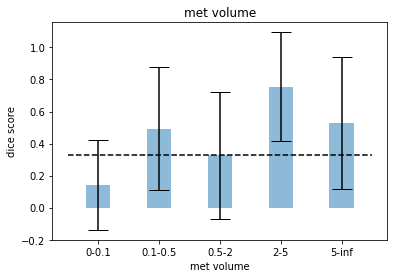

In [31]:
plt.bar(x,y,width=0.4, yerr=y_err, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.hlines(overall, -0.5,4.5, linestyles='dashed')
plt.xlabel('met volume')
plt.ylabel('dice score')
plt.title('met volume')
plt.savefig('met volume.png')

In [ ]:
for i in range(len(test_sample_mask[0][0])):
    plt.imshow(test_sample_mask[0][0][i].cpu())
    plt.show()

In [ ]:
for i in range(len(test_predicted_mask[0][0])):
    plt.imshow(test_predicted_mask[0][0][i].cpu())
    plt.show()

### Location

In [32]:
test_dataset = TestMetDataSet(test_df, None, None, 'right_front')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)

In [33]:
def location_eval(location):
    metrics = compute_per_channel_dice
    model.eval()
    total_test_loss = 0
    total_test_score = []
    total = 0
    for index, test_batch in tqdm(
        enumerate(
            test_loader), total=len(
            test_loader)):
        test_sample_img, test_sample_mask = test_batch
        test_sample_img = test_sample_img.to(device).float()
        test_sample_mask = test_sample_mask.to(device).float()
        if test_sample_mask.max() == 1:
            total += 1
            del test_batch
            gc.collect()
            with torch.no_grad():
                test_predicted_mask = model(test_sample_img)
    #         if index==4:
    #                 break
            test_predicted_mask = torch.tensor(location_filter(test_predicted_mask.round().detach().cpu().numpy()[0][0], location)).reshape(1,1,64,256,256).to(device)
            test_score = metrics(test_predicted_mask, test_sample_mask)
#             print(index,'  ', test_score)
            total_test_score.append(test_score.item())
        #     break
            del test_sample_img, test_sample_mask, test_predicted_mask, test_score
            gc.collect()
    print('test_score: ' + str(sum(total_test_score) / total))
    print('test_std: ' + str(np.std(total_test_score) / total))
    torch.cuda.empty_cache()
    test_score = sum(total_test_score) / total

In [34]:
def location_met_eval(location):
    metrics = compute_per_channel_dice
    model.eval()
    total_test_loss = 0
    total_test_score = []
    total = 0
    for index, test_batch in tqdm(
        enumerate(
            test_loader), total=len(
            test_loader)):
        test_sample_img, test_sample_mask = test_batch
        test_sample_img = test_sample_img.to(device).float()
        test_sample_mask = test_sample_mask.to(device).float()
        if test_sample_mask.max() >= 1:
            del test_batch
            gc.collect()
            with torch.no_grad():
                test_predicted_mask = model(test_sample_img)
            for label in range(1, int(test_sample_mask.max())+1):
                test_sample_met_mask = test_sample_mask.cpu().numpy()
                test_sample_met_mask[(test_sample_met_mask!=label)&(test_sample_met_mask!=0)] = 0
                test_sample_met_mask[test_sample_met_mask==label] = 1
                test_predicted_met_mask = torch.tensor(cm_filter(test_sample_met_mask[0][0], test_predicted_mask.round().detach().cpu().numpy()[0][0])).reshape(1,1,64,256,256).to(device)
                test_sample_met_mask = torch.tensor(test_sample_met_mask).to(device)

                test_score = metrics(test_predicted_met_mask, test_sample_met_mask)
                total_test_score.append(test_score.item())
#                 print(test_score.item())
                total += 1
            del test_sample_img, test_sample_mask, test_predicted_mask, test_score
            gc.collect()
    print('test_score: ' + str(sum(total_test_score) / total))
    print('test_std: ' + str(np.std(total_test_score)))
    print('total_met: ' + str(total))
    torch.cuda.empty_cache()

In [35]:
test_dataset = TestMetDataSet(test_df, None, None, 'right_front', True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)
location_met_eval('right_front')

100%|██████████| 41/41 [00:25<00:00,  1.62it/s]

test_score: 0.40853017497630345
test_std: 0.41699910885444647
total_met: 21


In [36]:
test_dataset = TestMetDataSet(test_df, None, None, 'left_front', True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)
location_met_eval('left_front')

100%|██████████| 41/41 [00:20<00:00,  2.01it/s]

test_score: 0.38288529912630714
test_std: 0.37964231278003124
total_met: 15


In [37]:
test_dataset = TestMetDataSet(test_df, None, None, 'right_pos', True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)
location_met_eval('right_pos')

100%|██████████| 41/41 [00:23<00:00,  1.74it/s]

test_score: 0.28537041981789196
test_std: 0.3700911361379155
total_met: 22


In [38]:
test_dataset = TestMetDataSet(test_df, None, None, 'left_pos', True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)
location_met_eval('left_pos')

100%|██████████| 41/41 [00:37<00:00,  1.09it/s]

test_score: 0.3067327477993109
test_std: 0.3918576439859679
total_met: 39


In [39]:
test_dataset = TestMetDataSet(test_df, None, None, 'right_cerebellum', True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)
location_met_eval('right_cerebellum')

100%|██████████| 41/41 [00:26<00:00,  1.57it/s]


test_score: 0.3793210523823897
test_std: 0.3909222921984641
total_met: 24


In [40]:
test_dataset = TestMetDataSet(test_df, None, None, 'left_cerebellum', True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)
location_met_eval('left_cerebellum')

100%|██████████| 41/41 [00:18<00:00,  2.22it/s]

test_score: 0.2128835441544652
test_std: 0.3460095839407753
total_met: 16


In [46]:
x = ['right_front', 'left_front', 'right_pos', 'left_pos', 'right_cere', 'left_cere']
y = [0.409, 0.383, 0.285, 0.307, 0.379, 0.213]
y_err = [0.417, 0.379, 0.370, 0.391, 0.39, 0.346]
overall = 0.329

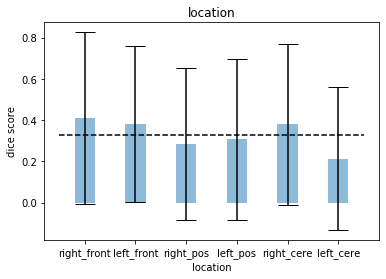

In [47]:
plt.bar(x,y,width=0.4, yerr=y_err, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.hlines(overall, -0.5,5.5, linestyles='dashed')
plt.xlabel('location')
plt.ylabel('dice score')
plt.title('location')
plt.savefig('location.png')

In [ ]:
for i in range(len(test_sample_mask[0][0])):
    plt.imshow(test_sample_mask[0][0][i].cpu())
    plt.show()

In [ ]:
for i in range(len(test_predicted_mask[0][0])):
    plt.imshow(test_predicted_mask[0][0][i].round().cpu())
    plt.show()

In [21]:
aha = torch.tensor(location_filter(test_predicted_mask.round().detach().cpu().numpy()[0][0], 'right_front')).reshape(1,1,64,256,256).to(device)

In [ ]:
for i in range(len(test_predicted_mask[0][0])):
    plt.imshow(aha[0][0][i].cpu())
    plt.show()

### Number

In [49]:
def num_eval():
    for num_bin in [[1,1],[2,2],[3,5],[6,10],[11,np.inf]]:
        test_dataset = TestMetDataSet(test_df, num_bin, None, None)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)

        metrics = compute_per_channel_dice
        model.eval()
        total_test_loss = 0
        total_test_score = []
        for index, test_batch in tqdm(
            enumerate(
                test_loader), total=len(
                test_loader)):
            test_sample_img, test_sample_mask = test_batch
            test_sample_img = test_sample_img.to(device).float()
            test_sample_mask = test_sample_mask.to(device).float()
            if test_sample_mask.max() == 1:
                del test_batch
                gc.collect()
                with torch.no_grad():
                    test_predicted_mask = model(test_sample_img)
                test_score = metrics(test_predicted_mask, test_sample_mask)
                total_test_score.append(test_score.item())
            #     break
                del test_sample_img, test_sample_mask, test_predicted_mask, test_score
                gc.collect()
        print('bin: ', num_bin)
        print('test_score: ' + str(sum(total_test_score) / len(test_dataset)))
        print('test_score_std: ' + str(np.std(total_test_score)))
        torch.cuda.empty_cache()

In [50]:
def num_fp():
    for num_bin in [[1,1],[2,2],[3,5],[6,10],[11,np.inf]]:
        test_dataset = TestMetDataSet(test_df, num_bin, None, None, False)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=False, num_workers=4)

        metrics = compute_per_channel_dice
        model.eval()
        total_test_loss = 0
        total_fp = []
        total_num_pred = []
        total_num_target = []
        for index, test_batch in tqdm(
            enumerate(
                test_loader), total=len(
                test_loader)):
            test_sample_img, test_sample_mask = test_batch
            test_sample_img = test_sample_img.to(device).float()
            test_sample_mask = test_sample_mask.to(device).float()

            del test_batch
            gc.collect()
            with torch.no_grad():
                test_predicted_mask = model(test_sample_img)
            total_num_target.append(ndimage.label(test_sample_mask.cpu().numpy()[0][0],structure_array)[0].max())
            total_num_pred.append(ndimage.label(test_predicted_mask.cpu().numpy()[0][0].round(),structure_array)[0].max())
#             return ndimage.label(test_sample_mask.cpu().numpy()[0][0])[0], ndimage.label(test_predicted_mask.cpu().numpy()[0][0].round())[0]
#             print(ndimage.label(test_predicted_mask.cpu().numpy()[0][0].round())[0].max())
            fp = fp_filter(test_sample_mask[0][0], test_predicted_mask.round().detach().cpu().numpy()[0][0])
            total_fp.append(fp)
            del test_sample_img, test_sample_mask, test_predicted_mask
            gc.collect()
        print('bin: ', num_bin)
        print('total FP: ' + str(sum(total_fp)))
        print('total num predicted: ' + str(sum(total_num_pred)))
        print('total num target: ' + str(sum(total_num_target)))
    #         print('FP rate: ' + str(sum(total_fp)/len(test_loader)))
        torch.cuda.empty_cache()

In [51]:
num_fp()

100%|██████████| 34/34 [00:36<00:00,  1.07s/it]

bin:  [1, 1]
total FP: 66
total num predicted: 115
total num target: 107



100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

bin:  [2, 2]
total FP: 2
total num predicted: 7
total num target: 15



100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

bin:  [3, 5]
total FP: 4
total num predicted: 11
total num target: 15



0it [00:00, ?it/s]

bin:  [6, 10]
total FP: 0
total num predicted: 0
total num target: 0



0it [00:00, ?it/s]

bin:  [11, inf]
total FP: 0
total num predicted: 0
total num target: 0


In [28]:
x = ['1', '2', '3-5', '6-10','11+']
y = [0.849, 0.801, 0.808, 0.742, 0.668]
y_err = [0.11, 0.14, 0.12, 0.14, 0.18]
overall = 0.791

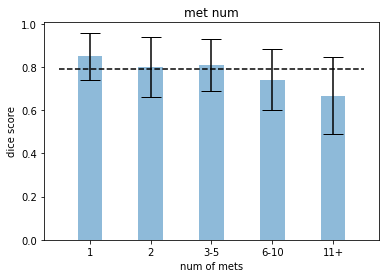

In [30]:
plt.bar(x,y,width=0.4,yerr=y_err, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.hlines(overall, -0.5,4.5, linestyles='dashed')
plt.xlabel('num of mets')
plt.ylabel('dice score')
plt.title('met num')
plt.savefig('met_num.png')

In [28]:
x = ['1', '2', '3-5', '6-10','11+']
y = [0.849, 0.801, 0.808, 0.742, 0.668]
overall = 0.198

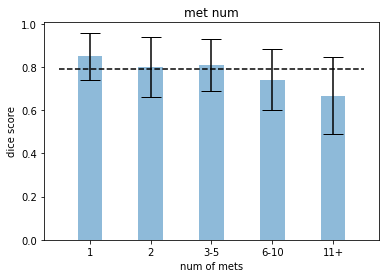

In [30]:
plt.bar(x,y,width=0.4,yerr=y_err, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.hlines(overall, -0.5,4.5, linestyles='dashed')
plt.xlabel('num of mets')
plt.ylabel('dice score')
plt.title('met num')
plt.savefig('met_num.png')